In [201]:
import numpy as np
import pandas as pd
import seaborn as sns
from functools import reduce
import matplotlib.pyplot as plt
from datetime import timedelta  

march_data = pd.read_csv('march2020.csv')
may_data = pd.read_csv('may2020.csv')
july_data = pd.read_csv('july2020.csv')
tweet_data = pd.read_excel('query-hive-135.xlsx')

#making copies of each dataframe
march = march_data.copy()
may = may_data.copy()
july = july_data.copy()
tweet = tweet_data.copy()

#using date as index
march['Date'] = pd.to_datetime(march['Date'])
may['Date'] = pd.to_datetime(may['Date'])
july['Date'] = pd.to_datetime(july['Date'])

#removes timestamp from date/time
march['Date'] = march['Date'].dt.date
may['Date'] = may['Date'].dt.date
july['Date'] = july['Date'].dt.date

#keep only the date for tweet data
tweet['trump_filtered.created_at'] = pd.to_datetime(tweet['trump_filtered.created_at']).dt.date
tweet_date = tweet['trump_filtered.created_at'].copy()

#creating a combined dataframe with one column corresponding to the open, low, high and close price for each month
dataFrames = [march, may, july]
df = reduce(lambda  left,right: pd.merge(left,right,on=['Date'], how='outer', suffixes = ('_march','_may')), dataFrames)
df.rename(columns={'Open': 'Open_july', 'High': 'High_july', 'Low':'Low_july','Close':'Close_july'}, inplace=True)

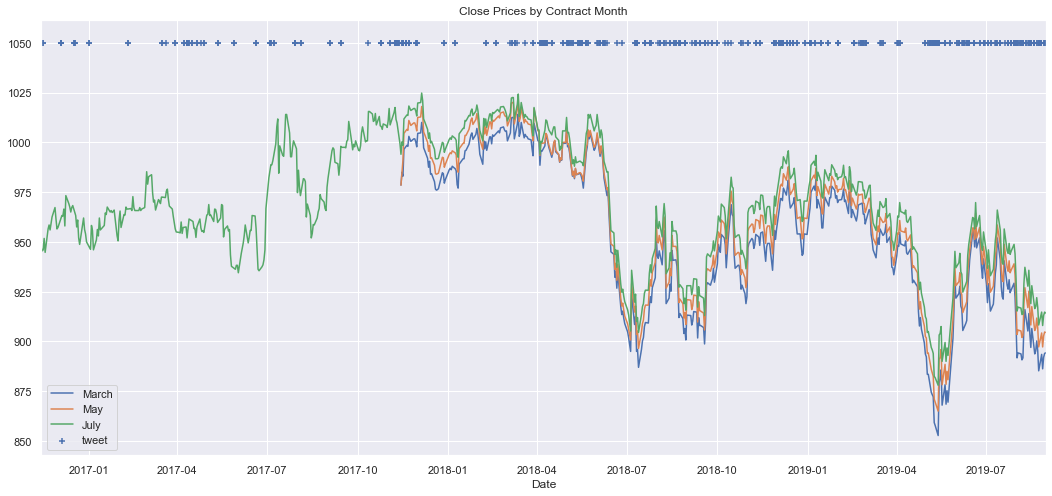

In [202]:
# Plot the contract data to verify the patterns
sns.set(rc={'figure.figsize':(18, 8)})
plot1 = df.plot(x='Date', y=['Close_march', 'Close_may', 'Close_july'], label = ['March','May','July'], title = 'Close Prices by Contract Month')
plot2 = plt.scatter(tweet_date,np.ones((tweet_date.shape[0],))*1050, marker='+', label='tweet')
plot2 = plt.legend()

### adding tweet on the time series data doesn't provide much information.

### Let's try to find tweets that contribute to large change in price percentage on the same day. Here we select july contract month because it has the longest period

Standard Deviation:  0.8575337378897183


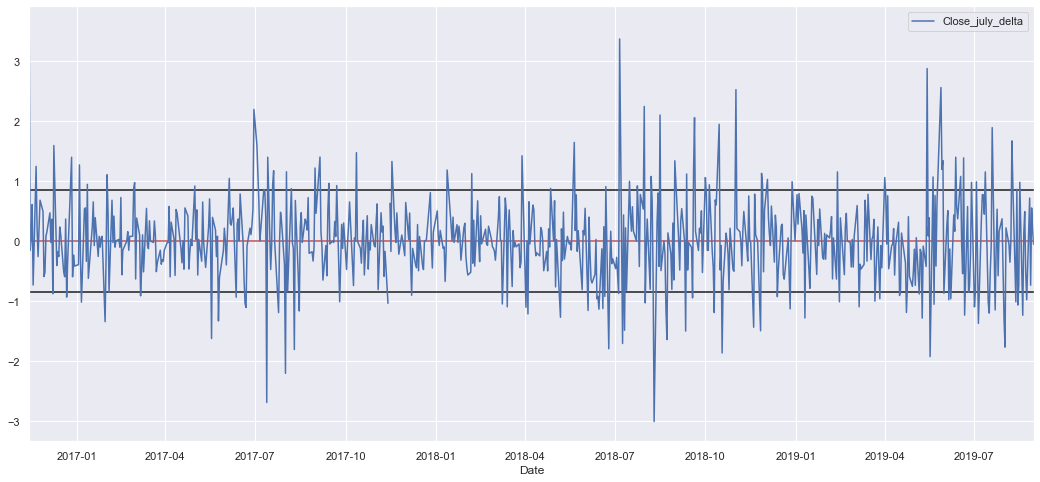

In [223]:
july_delta = df[['Date','Close_july']].copy()
july_delta.loc[0,'Close_july'] = None
july_delta.rename(columns={'Close_july':'Close_july_delta'}, inplace=True)
for i in range(1,july_delta.shape[0]):
    july_delta.loc[i,'Close_july_delta'] = (df.loc[i,'Close_july']-df.loc[i-1,'Close_july'])/df.loc[i-1,'Close_july']*100
plot3 = july_delta.plot(x='Date')

# find standard deviation of close delta
julyD_std = july_delta.std().values[0]*1.2
print('Standard Deviation: ', julyD_std)
plot4 = plt.hlines([julyD_std,-julyD_std],july_delta['Date'].min(),july_delta['Date'].max())
plot5 = plt.hlines(0,july_delta['Date'].min(),july_delta['Date'].max(),color='r')

### here we consider points that are above or below the standard deviation * 1.2 (black lines)

In [224]:
above = july_delta['Close_july_delta']>julyD_std
below = july_delta['Close_july_delta']<-julyD_std
july_significant = july_delta[[a or b for a,b in zip(above,below)]]

day = july_significant['Date'] # - timedelta(days=1)
bool_trump = np.zeros((tweet_date.shape[0],),dtype=bool)
delta_trump = []
for i,idate in enumerate(tweet_date):
    for j,jdate in enumerate(day):
        if idate == jdate:
            bool_trump[i]=True
            delta_trump.append(july_significant.iloc[j,:])
            break
tweet_significant = tweet[bool_trump].reset_index(drop=True).sort_values(by=['trump_filtered.created_at'])
delta_trump = np.array(delta_trump)[tweet_significant.index]
tweet_significant.head()

### Got the tweets in which causes the market to significantly up or down the same day

,trump_filtered.source,trump_filtered.text,trump_filtered.created_at,trump_filtered.retweet_count,trump_filtered.favorite_count,trump_filtered.is_retweet,trump_filtered.id_str
55,Twitter for iPhone,China has a business tax rate of 15%. We shoul...,2017-09-14,17849,76499,False,908154067658174469
111,Twitter for iPhone,China has a business tax rate of 15%. We shoul...,2017-09-14,17849,76499,False,908154067658174469
138,Twitter for iPhone,Happy #NationalFarmersDay!📸https://t.co/dN39R1...,2017-10-12,11002,50217,False,918571860308254720
54,Twitter for iPhone,We are not in a trade war with China that war ...,2018-04-04,37281,144378,False,981492087328792577
110,Twitter for iPhone,We are not in a trade war with China that war ...,2018-04-04,37281,144378,False,981492087328792577


### Print out all the tweets

In [225]:
for i in range(tweet_significant.shape[0]):
    print(tweet_significant.iloc[i,1], '\n', 'Day:', delta_trump[i][0], ', Price Percentage Change: ', delta_trump[i][1], '\n\n')

China has a business tax rate of 15%. We should do everything possible to match them in order to win with our economy. Jobs and wages! 
 Day: 2017-09-14 , Price Percentage Change:  0.9610520991401114 


China has a business tax rate of 15%. We should do everything possible to match them in order to win with our economy. Jobs and wages! 
 Day: 2017-09-14 , Price Percentage Change:  0.9610520991401114 


Happy #NationalFarmersDay!📸https://t.co/dN39R1IMlA https://t.co/QbUG1pztaI 
 Day: 2017-10-12 , Price Percentage Change:  1.4738945790657008 


We are not in a trade war with China that war was lost many years ago by the foolish or incompetent people who represented the U.S. Now we have a Trade Deficit of $500 Billion a year with Intellectual Property Theft of another $300 Billion. We cannot let this continue! 
 Day: 2018-04-04 , Price Percentage Change:  -1.2173913043478262 


We are not in a trade war with China that war was lost many years ago by the foolish or incompetent people who r